In [1]:
import numpy as np
import pandas as pd

# Load Data

In [2]:
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

movies = pd.read_csv('ml-100k/u.item', sep='|', names=[
    'movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL',
    'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama',
    'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
], encoding='latin-1')

users = pd.read_csv('ml-100k/u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

genres = pd.read_csv('ml-100k/u.genre', sep='|', names=['genre_id', 'genre_name'])

occupations = pd.read_csv('ml-100k/u.occupation', sep='|', names=['occupation_name'])

# Graphs

<Axes: title={'center': 'Rating Distribution'}, xlabel='Rating', ylabel='Count'>

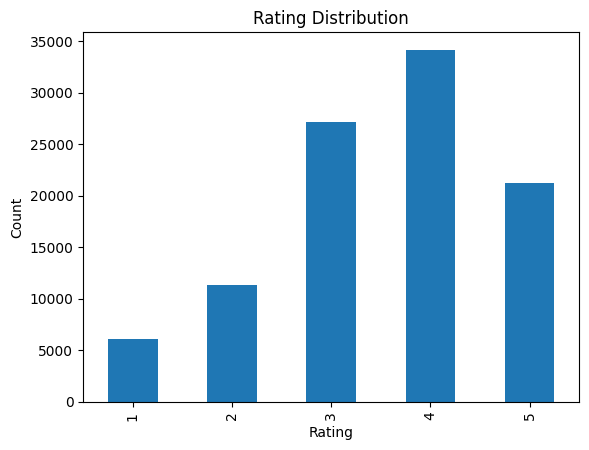

In [3]:
ratings['rating'].value_counts().sort_index().plot(kind='bar', title='Rating Distribution', xlabel='Rating', ylabel='Count')

<Axes: title={'center': 'Gender Breakdown'}, ylabel='count'>

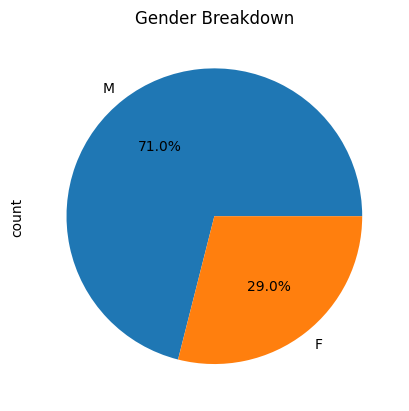

In [4]:
users['gender'].value_counts().plot(kind='pie', title='Gender Breakdown', autopct='%1.1f%%')

<Axes: title={'center': 'Age Distribution'}, xlabel='Age', ylabel='Frequency'>

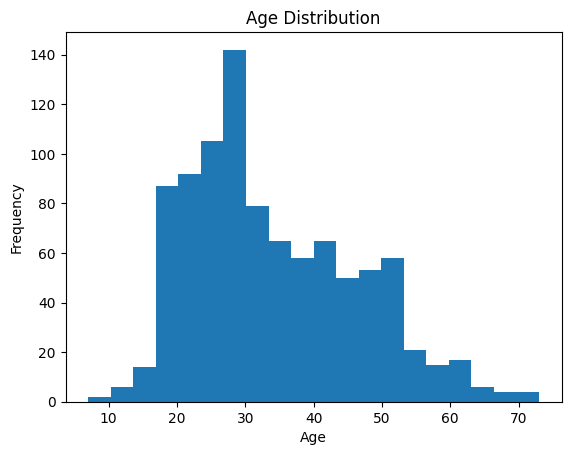

In [5]:
users['age'].plot(kind='hist', bins=20, title='Age Distribution', xlabel='Age')

# Implement Collaborative Filtering

In [23]:
from scipy.sparse.linalg import svds

In [28]:
df_rating = ratings.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

df_rating = df_rating.to_numpy()

# normalize data
rating_mean = np.mean(df_rating, axis=1)
df_rating_norm = df_rating - rating_mean.reshape(-1, 1)

In [31]:
# perform SVD
u, sigma, vt = svds(df_rating_norm, k=50)

sigma = np.diag(sigma)

# reconstruct the matrix
df_rating = np.dot(np.dot(u, sigma), vt) + rating_mean.reshape(-1, 1)

df_pred = pd.DataFrame(df_rating, columns=ratings['item_id'].unique())

# Evaluate the Model

In [32]:
from sklearn.metrics import mean_squared_error
import math

In [43]:
df_rating_pred = pd.DataFrame(df_pred.stack(), columns=['predicted_raitng']).reset_index()
df_rating_pred.columns = ['user_id', 'item_id', 'predicted_rating']
df_actual_rating = ratings.merge(df_rating_pred, on=['user_id', 'item_id'])

rmse = math.sqrt(mean_squared_error(df_actual_rating['rating'], df_actual_rating['predicted_rating']))

In [45]:
print(f"RMSE: {rmse}")
print("The model is not as accurate as expected, but it is still a good start for a recommendation system.")

RMSE: 3.4374706377481146
The model is not as accurate as expected, but it is still a good start for a recommendation system.


# Improve Model Performance

In [49]:
def svd_model(k):
  u, sigma, vt = svds(df_rating_norm, k=k)
  sigma = np.diag(sigma)
  
  # reconstruct the matrix
  df_rating = np.dot(np.dot(u, sigma), vt) + rating_mean.reshape(-1, 1)

  df_pred = pd.DataFrame(df_rating, columns=ratings['item_id'].unique())
  
  df_rating_pred = pd.DataFrame(df_pred.stack(), columns=['predicted_raitng']).reset_index()
  df_rating_pred.columns = ['user_id', 'item_id', 'predicted_rating']
  df_actual_rating = ratings.merge(df_rating_pred, on=['user_id', 'item_id'])

  rmse = math.sqrt(mean_squared_error(df_actual_rating['rating'], df_actual_rating['predicted_rating']))
  
  return rmse

In [50]:
for k in [20, 50, 100, 200]:
  print(f"RMSE with k = {k}: {svd_model(k)}")

RMSE with k = 20: 3.4149884488289284
RMSE with k = 50: 3.4374706377481146
RMSE with k = 100: 3.461256920350948
RMSE with k = 200: 3.4887735171257828


In [51]:
print("As k value increases, the RMSE value remains the same. This is because the model is overfitting the data. The model is not generalizing well to new data.")

As k value increases, the RMSE value remains the same. This is because the model is overfitting the data. The model is not generalizing well to new data.


# Generate Recommendation

In [66]:
def recom_move(user_id, n=10):
  user_row = user_id - 1
  sorted_pred = df_pred.iloc[user_row].sort_values(ascending=False)
  recom = sorted_pred.head(n)
  recom_id = recom.index
  return movies[movies['movie_id'].isin(recom_id)]['movie_title'].reset_index(drop=True)

In [67]:
for i in users['user_id']:
  print(f"User {i} Recommendations:")
  print(recom_move(i, 5))
  print()

User 1 Recommendations:
0              Monty Python's Life of Brian (1979)
1                                     Kolya (1996)
2                     It's a Wonderful Life (1946)
3                                Saint, The (1997)
4    Romy and Michele's High School Reunion (1997)
Name: movie_title, dtype: object

User 2 Recommendations:
0                              Bio-Dome (1996)
1                 It's a Wonderful Life (1946)
2    Lawnmower Man 2: Beyond Cyberspace (1996)
3                       Peacemaker, The (1997)
4                    Dazed and Confused (1993)
Name: movie_title, dtype: object

User 3 Recommendations:
0                        George of the Jungle (1997)
1    Once Upon a Time... When We Were Colored (1995)
2                                    Spy Hard (1996)
3                                     Kingpin (1996)
4          Lawnmower Man 2: Beyond Cyberspace (1996)
Name: movie_title, dtype: object

User 4 Recommendations:
0                                         Fargo